Автори коду: *Володимир Мотика* та *Ярослав Степаняк*

Основу взято з:

A Novel Architecture for Web-Based Attack Detection Using
Convolution Neural Network
Adem TEKEREK
PII: S0167-4048(20)30369-2
DOI: https://doi.org/10.1016/j.cose.2020.102096

Reference: COSE 102096
To appear in: Computers & Security
Received date: 13 April 2020
Revised date: 29 September 2020
Accepted date: 22 October 2020

Please cite this article as: Adem TEKEREK , A Novel Architecture for Web-Based Attack
Detection Using Convolution Neural Network, Computers & Security (2020), 
doi:https://doi.org/10.1016/j.cose.2020.102096

___

Основним етапом є підготовка даних для тренування моделі

Цей етап складається із двох:

1. Створення словника
2. Створення матриць

Більш детально описано дальше

___
Першим етапом є створення словника <br>
Словник містиме аномальні корисні навантаження (payload), як ключі <br>
Значення до ключа поки що нас не інтересують

In [1]:
# Імпортування необхідних на даний момент бібліотек
# та зчитування датасету з аномальними(!) даними

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_data = pd.read_csv("anomalousTrafficTest.txt",sep="/n/n", header= None)
raw_data

C:\Users\Admin\AppData\Local\Temp\ipykernel_14984\3144564507.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv("anomalousTrafficTest.txt",sep="/n/n", header= None)


,0
0,GET http://localhost:8080/tienda1/publico/anad...
1,User-Agent: Mozilla/5.0 (compatible; Konqueror...
2,Pragma: no-cache
3,Cache-control: no-cache
4,"Accept: text/xml,application/xml,application/x..."
...,...
305641,"Accept-Charset: utf-8, utf-8;q=0.5, *;q=0.5"
305642,Accept-Language: en
305643,Host: localhost:8080
305644,Cookie: JSESSIONID=3CC12010CDA952F123240EBAD79...


Потрібно почистити дані, оскільки є багато непотрібної інформації <br><br>
Оскільки все, що нам потрібно - це URL та відповідне корисне навантаження (Payload), то нам потрібні лише рядки, що містять в собі 'GET'

In [2]:
# Фільтрація рядків, що містять слово 'GET'
URL_Payload = raw_data[raw_data[0].str.contains('GET') == True ]

# Видалення слів, що не містять жодної корисної інформації 'GET' та 'HTTP/1.1'
URL_Payload.loc[:, 0] = URL_Payload[0].apply(lambda x: 
    x.replace("GET ", "").replace(" HTTP/1.1",""))

# Розділяємо посилання (URL) та корисне навантаження (Payload) та отримуємо два стовпці значень
URL_Payload[['URL', 'payload']] = URL_Payload[0].str.split('?', expand=True)
URL_Payload = URL_Payload[['URL', 'payload']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_14984\4087905454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  URL_Payload.loc[:, 0] = URL_Payload[0].apply(lambda x:
C:\Users\Admin\AppData\Local\Temp\ipykernel_14984\4087905454.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  URL_Payload[['URL', 'payload']] = URL_Payload[0].str.split('?', expand=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14984\4087905454.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Переходимо безпосередньо до створення словника <br>
Для його створення використовується модель "Торба слів" (bag-of-words)

In [3]:
import nltk     # бібліотека для обробки природної мови
import re       # регулярні вирази

Кожне корисне навантаження розділене символом '&' <br>
Розділяємо корисні навантаження аномальних даних і додаємо їх в словник як ключ, як відповідне до ключа значення обираємо звичайний лічильник 

In [4]:
# Initialize an empty dictionary
dict_filter = {}

# Iterate over the rows in the dataframe
for rdata in URL_Payload[URL_Payload['payload'].notna()].payload:
  # Tokenize the data using the '&' delimiter
  words = nltk.tokenize.regexp_tokenize(rdata, pattern=r"&", gaps=True)
  # Iterate over the words
  for word in words:
    # Check if the word is in the dictionary
    if word not in dict_filter:
      # If not, add it with a count of 1
      dict_filter[word] = 1
    else:
      # If it is, increment the count
      dict_filter[word] += 1

Словник dict_filter ініціалізований, отже перший етап підготовки даних завершено <br>
Далі переходимо безпосередньо до побудови матриць

In [19]:
dict_filter

{'id=2': 375,
 'nombre=Jam%F3n+Ib%E9rico': 318,
 'precio=85': 334,
 'cantidad=%27%3B+DROP+TABLE+usuarios%3B+SELECT+*+FROM+datos+WHERE+nombre+LIKE+%27%25': 3,
 'B1=A%F1adir+al+carrito': 1192,
 'id=2%2F': 46,
 'cantidad=49': 7,
 'modo=entrar': 1183,
 'login=bob%40%3CSCRipt%3Ealert%28Paros%29%3C%2FscrIPT%3E.parosproxy.org': 5,
 'pwd=84m3ri156': 2,
 'remember=on': 554,
 'B1=Entrar': 1173,
 'login=grimshaw': 2,
 'pwd=G%2F%2FlAc%2CIAr': 1,
 'rememberA=on': 42,
 'idA=2': 251,
 'errorMsg=%2B': 10,
 'errorMsgA=Credenciales+incorrectas': 444,
 'modo=insertar': 1064,
 'precio=183%27%2C%270%27%2C%270%27%29%3Bwaitfor+delay+%270%3A0%3A15%27%3B--': 1,
 'B1=Pasar+por+caja': 281,
 'precio=183': 2,
 'B1=Pasar+por+caja%2F': 214,
 'B1A=Pasar+por+caja': 68,
 'modo=registro%253CSCRIPT%253Ealert%2528%2522Paros%2522%2529%253B%253C%252FSCRIPT%253E': 1,
 'login=armand': 3,
 'password=prusiato': 4,
 'nombre=Samia': 3,
 'apellidos=Catalayud+Mirabet': 4,
 'email=balademas.mareuil6%40enlanzarote.com.vc': 4,
 'dni=2

Другий крок - побудова матриць <br>
Для цього ми напишемо функцію

Функція produce_matrixs_df приймає два аргументи:
<br> samples - набір даних, що містить корисні навантаження (Payloads)
<br> dict_filter - Dictionary, що містить у своїх ключах аномальні корисні навантаження<br><br>
Функція для кожної URL в samples створює бінарну матрицю. <br>Кількість елементів матриці має бути не менше ніж розмір словника.<br>
Функція проходить по кожному корисному навантаженню у даному HTTP запиті, і якщо корисне навантаження містить в словнику аномалій (змінна dict_filter), то відповідний елемент в матриці буде рівний 1, що означатиме наявність аномалій в матриці
<br>
Функція повертає список матриць

In [1]:
def produce_matrixs_df(samples, dict_filter):
    # Initialize an empty list to store the matrices
    matrixs_df = []
    
    # Iterate over the samples
    for sample in samples:
        # Initialize a matrix of zeros with dimensions (15000,)
        matrix = np.zeros((15000))
        
        # Tokenize the sample using the '&' character as the delimiter
        sample_tokenized = nltk.tokenize.regexp_tokenize(sample, pattern=r"&", gaps=True)
        
        # Create a dictionary with keys corresponding to the tokenized elements
        # and values of 1 if the element is in the dict_filter dictionary, or 0 otherwise
        dict_v2 = {}
        for el in sample_tokenized:
            if el in dict_filter:
                dict_v2[el] = 1
            else:
                dict_v2[el] = 0
        
        # Get the keys of the dict_filter dictionary
        dict_filter_keys = list(dict_filter.keys())

        # Iterate over the keys in the new dictionary, and find the corresponding index in the list of keys from dict_filter
        for key in dict_v2.keys():
            for i, df_key in enumerate(dict_filter_keys):
                if key == df_key:
                    # Set the value of the matrix at this index to 1
                    matrix[i] = 1
                    
        # Reshape the matrix to dimensions (124, 124) and append it to the list of matrices
        matrixs_df.append(matrix.reshape(150,100))
    
    # Return the list of matrices
    return matrixs_df

Далі завантажимо інші наші дані і здійснимо ті ж маніпуляції, що для аномальних спочатку

In [6]:
raw_data_norm_train = pd.read_csv("normalTrafficTraining.txt",sep="/n/n", header= None)
raw_data_norm_test = pd.read_csv("normalTrafficTest.txt",sep="/n/n", header= None)
raw_data_norm = pd.concat([raw_data_norm_train,raw_data_norm_test])

URL_Payload_norm = raw_data_norm[raw_data_norm[0].str.contains('GET') == True ]

URL_Payload_norm.loc[:, 0] = URL_Payload_norm[0].apply(lambda x: 
    x.replace("GET ", "").replace(" HTTP/1.1",""))

URL_Payload_norm[['URL', 'payload']] = URL_Payload_norm[0].str.split('?', expand=True)
URL_Payload_norm = URL_Payload_norm[['URL', 'payload']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_14984\3543599310.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data_norm_train = pd.read_csv("normalTrafficTraining.txt",sep="/n/n", header= None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14984\3543599310.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data_norm_test = pd.read_csv("normalTrafficTest.txt",sep="/n/n", header= None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14984\3543599310.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Створимо матриці для нормальних даних і помітимо їх '0', що означатиме, що даний HTTP запит не є веб-атакою

In [7]:
samples_ = URL_Payload_norm[URL_Payload_norm["payload"].notnull()]
samples_ = samples_["payload"]

res = produce_matrixs_df(samples_,dict_filter) 
df_norm = pd.DataFrame({'matrix': res, 'label': 0})

Створимо матриці для даних, що містять корисні навантаження веб-атак, і помітимо їх '1', що означатиме, що даний HTTP запит є веб-атакою

In [8]:
samples_ = URL_Payload[URL_Payload["payload"].notnull()]
samples_ = samples_["payload"]

res = produce_matrixs_df(samples_,dict_filter) 
df_anom = pd.DataFrame({'matrix': res, 'label': 1})

In [9]:
df = pd.concat([df_norm,df_anom])
df.reset_index(inplace=True)
df=df.drop('index',axis=1)

Після об'єднання отримали набір даних із бінарнею матрицею та позначенням чи є даних запит веб-атакою 

In [11]:
df

,matrix,label
0,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0
2,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
...,...,...
25604,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
25605,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
25606,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
25607,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [11]:
df['matrix'][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Наступний блок коду візуалізує матрицю. Білі пікселі - аномалії

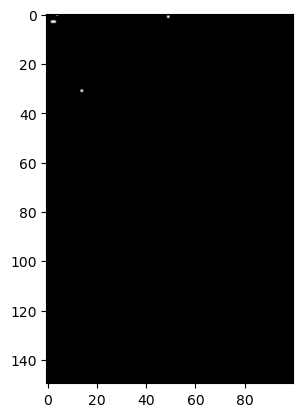

In [10]:
mat=np.asarray(df['matrix'][0]).astype('float32')

plt.imshow(mat, cmap='gray')
plt.axis('off')
plt.show()

___
Останній крок у підготовці даних, а саме: розділити дані на тренувальну та тестову вибірки і додати розмірність в дані (необхідно для того, щоб CNN модель змогла навчатись)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['matrix'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [50]:
X_train.shape

(20487,)

In [12]:
X_train = np.stack(X_train, axis=0)

# Add an additional dimension for the channels
X_train = np.expand_dims(X_train, axis=-1)

X_test = np.stack(X_test, axis=0)

# Add an additional dimension for the channels
X_test = np.expand_dims(X_test, axis=-1)

In [52]:
X_train.shape

(20487, 150, 100, 1)

івоашвіаооалдавідлалдівьлвіьалдвідатдлвітлдвімтл мтвімьлд бт

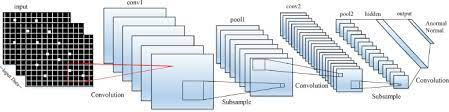

In [13]:
import tensorflow as tf
from tensorflow import keras
import itertools
import matplotlib.pyplot as plt

In [14]:
# Define the input shape for the matrices
input_shape = (150, 100, 1)

In [15]:
# Create the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (2,2),padding="same", activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (2,2),padding="same", activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [4]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5)

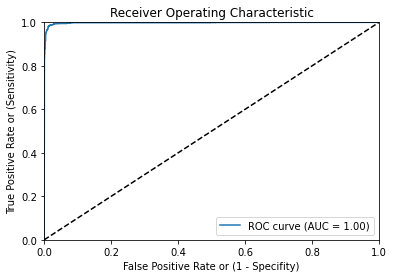

[[3164   34]
 [  56 1868]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3198
           1       0.98      0.97      0.98      1924

    accuracy                           0.98      5122
   macro avg       0.98      0.98      0.98      5122
weighted avg       0.98      0.98      0.98      5122



In [38]:
from keras.activations import softmax
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, precision_score, recall_score, classification_report

# Get the predicted probabilities for the test data
y_pred = model.predict(X_test)

y_pred_binary = np.round(y_pred)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(confusion_matrix(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))

for i in ['accuracy', 'loss']:
    acc = history.history[i]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training {}'.format(i))
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

----------------------
Poolings: (<class 'keras.layers.pooling.MaxPooling2D'>, <class 'keras.layers.pooling.MaxPooling2D'>)
----------------------
Epoch 1/5
641/641 [==============================] - 137s 212ms/step - loss: 0.1923 - accuracy: 0.9219
Epoch 2/5
641/641 [==============================] - 123s 192ms/step - loss: 0.0421 - accuracy: 0.9860
Epoch 3/5
641/641 [==============================] - 124s 194ms/step - loss: 0.0198 - accuracy: 0.9930
Epoch 4/5
641/641 [==============================] - 125s 195ms/step - loss: 0.0125 - accuracy: 0.9959
Epoch 5/5
641/641 [==============================] - 125s 196ms/step - loss: 0.0058 - accuracy: 0.9985


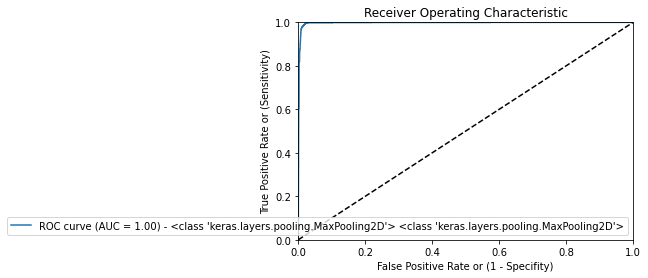

[[3153   47]
 [  34 1888]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3200
           1       0.98      0.98      0.98      1922

    accuracy                           0.98      5122
   macro avg       0.98      0.98      0.98      5122
weighted avg       0.98      0.98      0.98      5122



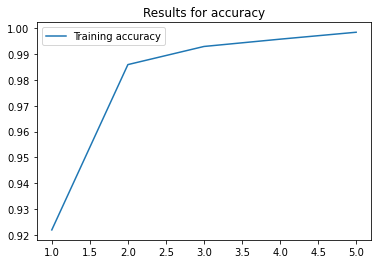

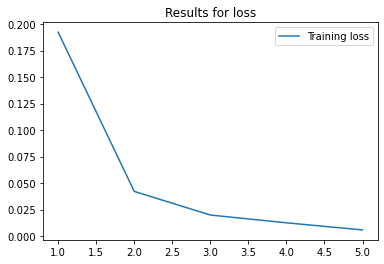

----------------------
Poolings: (<class 'keras.layers.pooling.MaxPooling2D'>, <class 'keras.layers.pooling.AveragePooling2D'>)
----------------------
Epoch 1/5
641/641 [==============================] - 111s 172ms/step - loss: 0.2095 - accuracy: 0.9119
Epoch 2/5
641/641 [==============================] - 106s 166ms/step - loss: 0.0559 - accuracy: 0.9808
Epoch 3/5
641/641 [==============================] - 105s 163ms/step - loss: 0.0300 - accuracy: 0.9905
Epoch 4/5
641/641 [==============================] - 104s 162ms/step - loss: 0.0191 - accuracy: 0.9944
Epoch 5/5
641/641 [==============================] - 104s 162ms/step - loss: 0.0156 - accuracy: 0.9959


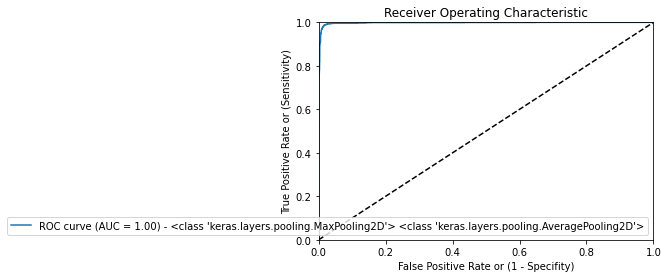

[[3142   58]
 [  24 1898]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3200
           1       0.97      0.99      0.98      1922

    accuracy                           0.98      5122
   macro avg       0.98      0.98      0.98      5122
weighted avg       0.98      0.98      0.98      5122



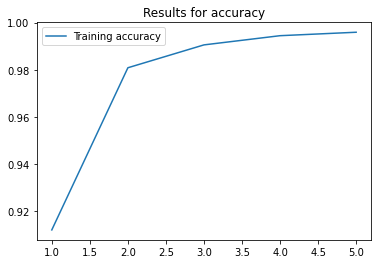

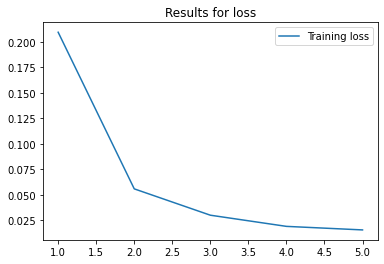

----------------------
Poolings: (<class 'keras.layers.pooling.AveragePooling2D'>, <class 'keras.layers.pooling.MaxPooling2D'>)
----------------------
Epoch 1/5
641/641 [==============================] - 103s 161ms/step - loss: 0.2017 - accuracy: 0.9145
Epoch 2/5
641/641 [==============================] - 104s 162ms/step - loss: 0.0474 - accuracy: 0.9842
Epoch 3/5
641/641 [==============================] - 101s 158ms/step - loss: 0.0213 - accuracy: 0.9942
Epoch 4/5
641/641 [==============================] - 102s 159ms/step - loss: 0.0102 - accuracy: 0.9972
Epoch 5/5
641/641 [==============================] - 106s 165ms/step - loss: 0.0098 - accuracy: 0.9973


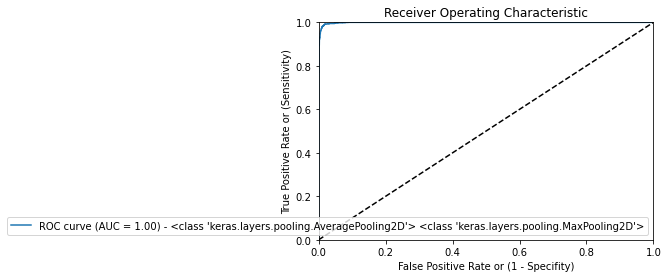

[[3169   31]
 [  47 1875]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3200
           1       0.98      0.98      0.98      1922

    accuracy                           0.98      5122
   macro avg       0.98      0.98      0.98      5122
weighted avg       0.98      0.98      0.98      5122



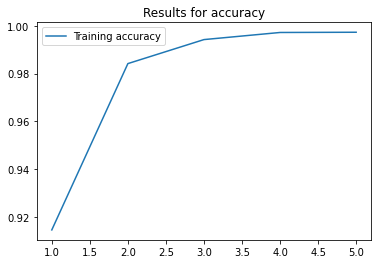

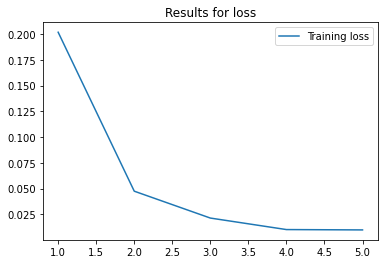

----------------------
Poolings: (<class 'keras.layers.pooling.AveragePooling2D'>, <class 'keras.layers.pooling.AveragePooling2D'>)
----------------------
Epoch 1/5
641/641 [==============================] - 103s 157ms/step - loss: 0.2578 - accuracy: 0.8934
Epoch 2/5
641/641 [==============================] - 102s 159ms/step - loss: 0.0663 - accuracy: 0.9768
Epoch 3/5
641/641 [==============================] - 102s 159ms/step - loss: 0.0341 - accuracy: 0.9887
Epoch 4/5
641/641 [==============================] - 103s 161ms/step - loss: 0.0205 - accuracy: 0.9938
Epoch 5/5
641/641 [==============================] - 100s 156ms/step - loss: 0.0156 - accuracy: 0.9959


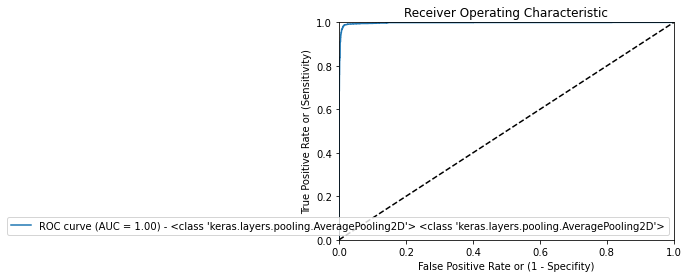

[[3166   34]
 [  49 1873]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3200
           1       0.98      0.97      0.98      1922

    accuracy                           0.98      5122
   macro avg       0.98      0.98      0.98      5122
weighted avg       0.98      0.98      0.98      5122



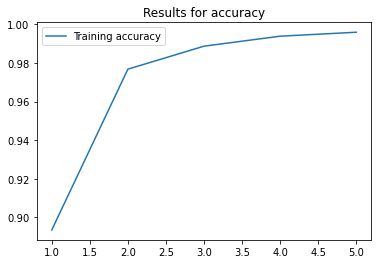

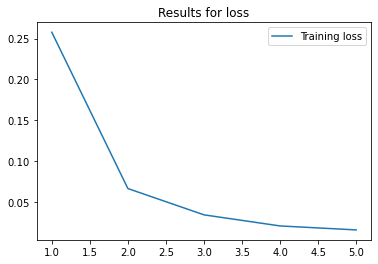

In [53]:
from itertools import product
import keras

# Define the input shape for the matrices
input_shape = (150, 100, 1)

# Define the possible pooling layers
pooling_layers = [keras.layers.MaxPooling2D, keras.layers.AveragePooling2D]

# Get all possible combinations of pooling layers
pooling_combinations = list(product(pooling_layers, repeat=2))

for pooling_combo in pooling_combinations:
    # Define the model
    model = keras.Sequential([
        keras.layers.Conv2D(32, (2,2),padding="same", activation='relu', input_shape=input_shape),
        pooling_combo[0](pool_size=(2, 2)),
        keras.layers.Conv2D(64, (2,2),padding="same", activation='relu'),
        pooling_combo[1](pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    print("----------------------")
    print("Poolings:",pooling_combo)
    print("----------------------")
    

    # Train the model
    history = model.fit(X_train, y_train, epochs=5)

    # Get the predicted probabilities for the test data
    y_pred = model.predict(X_test)

    y_pred_binary = np.round(y_pred)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f) - %s %s' % (roc_auc, pooling_combo[0], pooling_combo[1]))
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print(confusion_matrix(y_test, y_pred_binary))
    print(classification_report(y_test, y_pred_binary))

    for i in ['accuracy', 'loss']:
        acc = history.history[i]
        epochs = range(1, len(acc) + 1)
                       
        plt.figure()
        plt.plot(epochs, acc, label='Training {}'.format(i))
        plt.title('Results for {}'.format(i))
        plt.legend()
        plt.show()

In [7]:
#!pip install visualkeras
#!pip install ann_visualizer
#!pip install graphviz

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4172 sha256=61dd09c56fc5ccbd6d1726a3ce51116ae4a23ef3ecf938e6e6ae83214ce1a1b2
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\2d\d8\86\67f4a249969eaaa31c6df569f4ebfa84634fae3af2c627107b
Successfully built ann-visualizer


In [18]:
import netron
model.save("path/to/model.h5")
netron.start("path/to/model.h5")

Serving 'path/to/model.h5' at http://localhost:8080


('localhost', 8080)

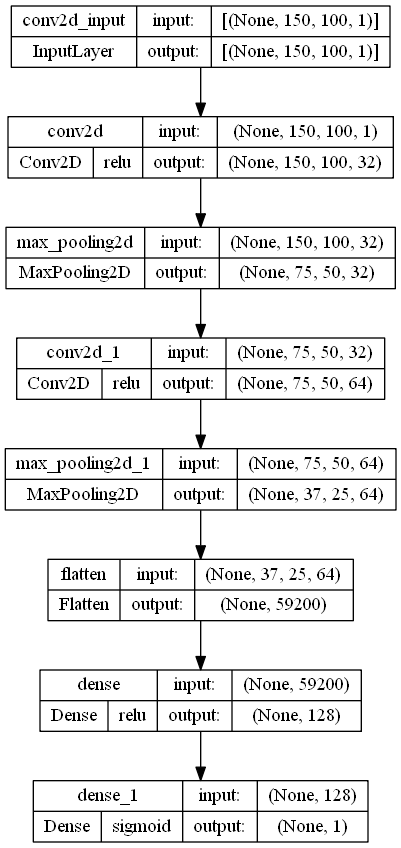

In [16]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

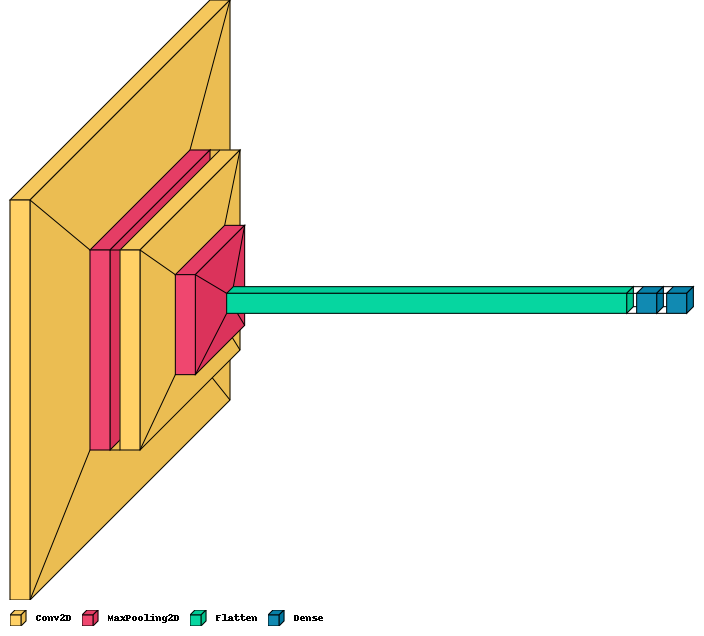

In [17]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

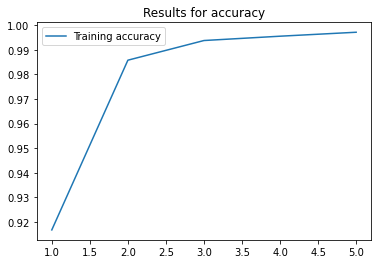

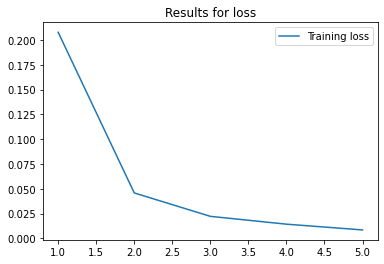

In [ ]:
for i in ['accuracy', 'loss']:
    acc = history.history[i]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training {}'.format(i))
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

In [ ]:
pooling_layers = [keras.layers.MaxPooling2D, keras.layers.AveragePooling2D]

accuracies = []
for pooling_layer in pooling_layers:
    # Create a new model with the current pooling layer
    model = keras.Sequential([
    keras.layers.Conv2D(32, (2,2),padding="same", activation='relu', input_shape=input_shape),
    pooling_layer(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (2,2),padding="same", activation='relu'),
    pooling_layer(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile and train the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5)
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    accuracies.append(test_acc)
    print(f'{pooling_layer.__name__} Test accuracy: {test_acc}')
    
# Plot the results
plt.bar(pooling_layers, accuracies)
plt.xlabel('Pooling Layer')
plt.ylabel('Accuracy')
plt.show()


In [32]:
y_train.shape

(20487,)

In [ ]:


# Define the input shape for the matrices
input_shape = (150, 100, 1)

pooling_layers = [keras.layers.MaxPooling2D, keras.layers.AveragePooling2D]

# Create a list of all possible combinations of pooling layers
combinations = list(itertools.product(pooling_layers, repeat=2))

accuracies = []
for comb in combinations:
    # Create a new model with the current combination of pooling layers
    model = keras.Sequential([
        keras.layers.Conv2D(32, (2,2),padding="same", activation='relu', input_shape=input_shape),
        comb[0](pool_size=(2, 2)),
        keras.layers.Conv2D(64, (2,2),padding="same", activation='relu'),
        comb[1](pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='softmax')
    ])
    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5)
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    accuracies.append(test_acc)
    print(f'{comb} Test accuracy: {test_acc}')

# Plot the results
plt.bar(range(len(combinations)), accuracies)
plt.xticks(range(len(combinations)), combinations, rotation=90)
plt.xlabel('Pooling Layer Combinations')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
history.history

{'loss': [0.20774871110916138,
  0.04583318158984184,
  0.022237390279769897,
  0.014348235912621021,
  0.008562609553337097],
 'accuracy': [0.9167276620864868,
  0.9857958555221558,
  0.993800938129425,
  0.9955581426620483,
  0.9971689581871033]}